In [1]:
import os
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
PATH = os.path.abspath('')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pd.set_option('display.max_columns', 500)
sns.set_style("ticks")

In [4]:
def perc_print(a, b):
    return round((a-b)/a*100)

## Importation des données

In [5]:
data = pd.read_csv(PATH+'/data/Données_nettoyées.csv', index_col=0, low_memory=False)

Aperçu de la base de donnée.

In [6]:
data.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,2010-339,Brisbane,Hard,32,A,2010-01-03,1,104053,Andy Roddick,R,188.0,USA,27.348392,103429,Peter Luczak,R,183.0,AUS,30.346338,7-6(5) 6-2,3,R32,84.0,15.0,0.0,63.0,42.0,36.0,14.0,10.0,3.0,3.0,4.0,2.0,56.0,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0,2010
1,2010-339,Brisbane,Hard,32,A,2010-01-03,2,104958,Carsten Ball,L,198.0,AUS,22.543463,104999,Mischa Zverev,L,190.0,GER,22.370979,7-5 6-1,3,R32,70.0,10.0,3.0,57.0,30.0,23.0,19.0,10.0,0.0,0.0,2.0,2.0,66.0,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0,2010
2,2010-339,Brisbane,Hard,32,A,2010-01-03,3,104755,Richard Gasquet,R,185.0,FRA,23.548255,103813,Jarkko Nieminen,L,185.0,FIN,28.451745,6-3 4-6 6-4,3,R32,121.0,5.0,4.0,97.0,51.0,33.0,27.0,15.0,5.0,8.0,4.0,0.0,85.0,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0,2010


Afin de créer des variables propres à chaque joueurs, nous retravaillons nos colonnes _winner_name_ et _loser_name_ en dédoublant chaque ligne pour obtenir une ligne par joueur du match renommée _player_name_ et son adversaire dans la colonne _opponent_name_

In [7]:
data_winner = data.copy()
data_loser = data.copy()
data_winner.rename({'winner_name':'player_name'}, inplace=True)
data_loser.rename({'loser_name':'player_name'}, inplace=True)
data_winner['win_lose'] = ['w' for i in range(len(data_winner))]
data_loser['win_lose'] = ['l' for i in range(len(data_loser))]
data_winner = data_winner.rename(columns=lambda x: re.sub('winner','player',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('^w_','player_',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('loser','opponent',x))
data_winner = data_winner.rename(columns=lambda x: re.sub('^l_','opponent_',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('loser','player',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('^l_','player_',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('winner','opponent',x))
data_loser = data_loser.rename(columns=lambda x: re.sub('^w_','opponent_',x))
data = pd.concat([data_winner, data_loser], axis=0, sort=False)
data.reset_index(inplace=True)

In [8]:
data.shape

(109030, 48)

## Création de variables relatives à la rencontre

Les attributs présents dans notre base sont les suivantes.

In [9]:
print('Features de base :')
print(data.columns.values)

Features de base :
['index' 'tourney_id' 'tourney_name' 'surface' 'draw_size' 'tourney_level'
 'tourney_date' 'match_num' 'player_id' 'player_name' 'player_hand'
 'player_ht' 'player_ioc' 'player_age' 'opponent_id' 'opponent_name'
 'opponent_hand' 'opponent_ht' 'opponent_ioc' 'opponent_age' 'score'
 'best_of' 'round' 'minutes' 'player_ace' 'player_df' 'player_svpt'
 'player_1stIn' 'player_1stWon' 'player_2ndWon' 'player_SvGms'
 'player_bpSaved' 'player_bpFaced' 'opponent_ace' 'opponent_df'
 'opponent_svpt' 'opponent_1stIn' 'opponent_1stWon' 'opponent_2ndWon'
 'opponent_SvGms' 'opponent_bpSaved' 'opponent_bpFaced' 'player_rank'
 'player_rank_points' 'opponent_rank' 'opponent_rank_points' 'year'
 'win_lose']


A partir de ces données initiales, nous allons créer de nouvelles features dans le but de maximiser le signal inclu dans nos attributs. 

### 3.1 Ecart de classement entre les deux joueurs

In [10]:
data['diff_ranking'] = data.apply(lambda x: abs(x.player_rank - x.opponent_rank), axis=1)
data['diff_ranking'].head(3)

0    70.0
1    56.0
2    36.0
Name: diff_ranking, dtype: float64

### 3.2 Classement moyen des deux joueurs du match

In [11]:
data['avg_ranking'] = data.apply(lambda x: (x.player_rank + x.opponent_rank)/2, axis=1)
data['avg_ranking'].head(3)

0     42.0
1    106.0
2     70.0
Name: avg_ranking, dtype: float64

### 3.3 Les joueurs jouent de la même main

In [12]:
data['same_hand'] = data.apply(lambda x: 1 if x['player_hand']!=x['opponent_hand'] else 0, axis=1)
data['same_hand'].head(3)

0    0
1    0
2    1
Name: same_hand, dtype: int64

##  Création des variables caractéristiques du joueur 

Suite au dédoublement de nos lignes, nous allons créer des features différentes en fonction de chaque joueur.

In [13]:
nb_joueur = data['player_name'].unique().shape[0]
print('Nombre de joueur différents dans notre base :', nb_joueur)

Nombre de joueur différents dans notre base : 1355


Nous distinguons à partir d'ici les observations relatives à des Best_of 3 / Best_of 5 (matchs en 2 ou 3 sets gagnants). 

In [14]:
data_bo5 = data[data['best_of']==5].copy()
data_bo3 = data[data['best_of']==3].copy()

data_bo5.shape[0] + data_bo3.shape[0] == data.shape[0]

True

### Temps de match moyen d'un joueur

In [15]:
mean_time = data_bo3.groupby(['player_name'])['minutes'].mean()
data_bo3['player_mean_time'] = np.zeros(data_bo3.shape[0])
data_bo3['player_mean_time'] = data_bo3.apply(lambda x: mean_time[x['player_name']], axis=1)
data_bo3[['player_name', 'player_mean_time']].head(3)

,player_name,player_mean_time
0,Andy Roddick,90.712480
1,Carsten Ball,84.166667
2,Richard Gasquet,95.957164


In [16]:
opp_mean_time = data_bo3.groupby(['opponent_name'])['minutes'].mean()
data_bo3['opponent_mean_time'] = np.zeros(data_bo3.shape[0])
data_bo3['opponent_mean_time'] = data_bo3.apply(lambda x: opp_mean_time[x['opponent_name']], axis=1)
data_bo3[['opponent_name', 'opponent_mean_time']].head(3)

,opponent_name,opponent_mean_time
0,Peter Luczak,99.491803
1,Mischa Zverev,92.526316
2,Jarkko Nieminen,92.392447


In [17]:
mean_time = data_bo5.groupby(['player_name'])['minutes'].mean()
data_bo5['player_mean_time'] = np.zeros(data_bo5.shape[0])
data_bo5['player_mean_time'] = data_bo5.apply(lambda x: mean_time[x['player_name']], axis=1)
data_bo5[['player_name', 'player_mean_time']].head(3)

,player_name,player_mean_time
143,Roger Federer,130.856818
144,Victor Hanescu,143.520548
145,Stephane Robert,132.026316


In [18]:
opp_mean_time = data_bo5.groupby(['opponent_name'])['minutes'].mean()
data_bo5['opponent_mean_time'] = np.zeros(data_bo5.shape[0])
data_bo5['opponent_mean_time'] = data_bo5.apply(lambda x: opp_mean_time[x['opponent_name']], axis=1)
data_bo5[['opponent_name', 'opponent_mean_time']].head(3)

,opponent_name,opponent_mean_time
143,Igor Andreev,149.647887
144,Juan Ignacio Chela,152.255319
145,Potito Starace,141.659091


### Temps moyen des 10 derniers matchs d'un joueur

On crée une moyenne mobile du temps moyen des 10 derniers matchs d'un joueur.

Cette opération étant amenée à être répétée, dans le but de rendre le code moins redondant nous créons une fonction qui nous permet de faire des variables représentant la dynamique d'un joueur.  

In [19]:
def dynamic_features(df, target_feature, new_feature_name, list_sort_features, window_size=10):
    # player
    player_new_feature_name = 'player_' + new_feature_name
    df[player_new_feature_name] = np.zeros(df.shape[0])
    df = df.sort_values(['player_name']+list_sort_features).copy()
    df[player_new_feature_name] = df.sort_values(['player_name']+list_sort_features).groupby('player_name')[target_feature].rolling(window=window_size,min_periods=1).mean().values
    df[player_new_feature_name+'_shifted'] = df.sort_values(['player_name']+list_sort_features).groupby('player_name')[player_new_feature_name].shift(1).values
    df.sort_values(['player_name']+list_sort_features, inplace=True)
    print(df[df['player_name']=='Roger Federer'][['player_name', target_feature, player_new_feature_name, player_new_feature_name+'_shifted']].head(5))
    print('\n')
    # opponent
    opponent_new_feature_name = 'opponent_' + new_feature_name
    df[opponent_new_feature_name] = np.zeros(df.shape[0])
    df = df.sort_values(['opponent_name']+list_sort_features).copy()
    df[opponent_new_feature_name] = df.sort_values(list_sort_features).groupby('opponent_name')[target_feature].rolling(window=window_size,min_periods=1).mean().values
    df[opponent_new_feature_name+'_shifted'] = df.sort_values(['opponent_name']+list_sort_features).groupby('opponent_name')[opponent_new_feature_name].shift(1).values
    df.sort_values(['opponent_name']+list_sort_features, inplace=True)
    print(df[df['opponent_name']=='Roger Federer'][['opponent_name', target_feature, opponent_new_feature_name, opponent_new_feature_name+'_shifted']].head(5))
    return df.copy()

Nous appliquons cette fonction.

In [20]:
data_bo3 = dynamic_features(df=data_bo3, target_feature='minutes', new_feature_name='mean_10time', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  minutes  player_mean_10time  player_mean_10time_shifted
3154   Roger Federer     45.0           45.000000                         NaN
57684  Roger Federer     84.0           64.500000                   45.000000
57110  Roger Federer     68.0           65.666667                   64.500000
4523   Roger Federer     72.0           67.250000                   65.666667
4537   Roger Federer     63.0           66.400000                   67.250000


       opponent_name  minutes  opponent_mean_10time  \
57669  Roger Federer     45.0             45.000000   
3169   Roger Federer     84.0             64.500000   
2595   Roger Federer     68.0             65.666667   
59038  Roger Federer     72.0             67.250000   
59052  Roger Federer     63.0             66.400000   

       opponent_mean_10time_shifted  
57669                           NaN  
3169                      45.000000  
2595                      64.500000  
59038                     65.666667  
59052    

In [21]:
data_bo5 = dynamic_features(df=data_bo5, target_feature='minutes', new_feature_name='mean_10time', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  minutes  player_mean_10time  player_mean_10time_shifted
5121   Roger Federer    125.0          125.000000                         NaN
5157   Roger Federer    106.0          115.500000                  125.000000
59691  Roger Federer    101.0          110.666667                  115.500000
4689   Roger Federer    147.0          119.750000                  110.666667
4725   Roger Federer    132.0          122.200000                  119.750000


       opponent_name  minutes  opponent_mean_10time  \
59636  Roger Federer    125.0            125.000000   
59672  Roger Federer    106.0            115.500000   
5176   Roger Federer    101.0            110.666667   
59204  Roger Federer    147.0            119.750000   
59240  Roger Federer    132.0            122.200000   

       opponent_mean_10time_shifted  
59636                           NaN  
59672                    125.000000  
5176                     115.500000  
59204                    110.666667  
59240    

### Nombre de jeux moyen joué par un joueur

Nous commencons par extraire le nombre de jeux joués dans chaque match.

In [22]:
data_bo3['nb_games'] = data_bo3.apply(lambda x: x['score'].split(' '), axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: [string.split('-') for string in x['nb_games']], axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: [[int(elt[0]) for elt in liste if len(elt)>0] for liste in x['nb_games']], axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: [sum(liste) for liste in x['nb_games']], axis=1)
data_bo3['nb_games'] = data_bo3.apply(lambda x: sum(x['nb_games']), axis=1)

In [23]:
data_bo5['nb_games'] = data_bo5.apply(lambda x: x['score'].split(' '), axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: [string.split('-') for string in x['nb_games']], axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: [[int(elt[0]) for elt in liste if len(elt)>0] for liste in x['nb_games']], axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: [sum(liste) for liste in x['nb_games']], axis=1)
data_bo5['nb_games'] = data_bo5.apply(lambda x: sum(x['nb_games']), axis=1)

In [24]:
data_bo3['nb_games'].unique()

array([14, 15, 13, 28, 19, 21, 24, 17, 18, 34, 16, 27, 32, 22, 20, 25, 23,
       26, 30, 31, 36, 35, 33, 29, 39, 38, 12, 37, 10, 11])

In [25]:
data_bo5['nb_games'].unique()

array([41, 28, 37, 36, 23, 32, 22, 26, 49, 29, 25, 53, 21, 50, 24, 30, 47,
       35, 46, 40, 27, 38, 31, 52, 43, 39, 48, 55, 51, 34, 33, 45, 42, 44,
       56, 59, 20, 54, 60, 19, 57, 66, 61, 58, 64, 65, 62, 15, 63])

Un match de tennis fait au minimum 12 jeux, l'analyse du nombre de set joué dans nos donnée nous indique que certaines rencontrent finissent après 10 et 11 jeux. Nous supprimons ces matchs car ils ne respectent pas ce seuil (l'abandon n'est pas notifié dans la base).

In [26]:
nb_obs = data_bo3.shape[0]
data_bo3 = data_bo3[data_bo3['nb_games']>=12].copy()
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo3.shape[0], perc_print(nb_obs, data_bo3.shape[0])))

6 observations supprimées (0%).


In [27]:
nb_obs = data_bo5.shape[0]
data_bo5 = data_bo5[data_bo5['nb_games']>=18].copy()
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo5.shape[0], perc_print(nb_obs, data_bo5.shape[0])))

2 observations supprimées (0%).


A partir du nombre de jeux joués dans un match, nous déterminons le nombre de sets joué en moyenne pour chaque joueur ainsi que son advsersaire.

In [28]:
data_bo3['player_mean_games'] = np.zeros(data_bo3.shape[0])
for player in data_bo3['player_name'].unique():
    player_mean_games = data_bo3[data_bo3['player_name']==player]['nb_games'].mean()
    data_bo3['player_mean_games'].loc[data_bo3[data_bo3['player_name']==player].index] = player_mean_games.copy()

/home/cesar/.anaconda3/envs/projetml/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
data_bo3['opponent_mean_games'] = np.zeros(data_bo3.shape[0])
for player in data_bo3['opponent_name'].unique():
    player_mean_games = data_bo3[data_bo3['opponent_name']==player]['nb_games'].mean()
    data_bo3['opponent_mean_games'].loc[data_bo3[data_bo3['opponent_name']==player].index] = player_mean_games.copy()

In [30]:
data_bo5['player_mean_games'] = np.zeros(data_bo5.shape[0])
for player in data_bo5['player_name'].unique():
    player_mean_games = data_bo5[data_bo5['player_name']==player]['nb_games'].mean()
    data_bo5['player_mean_games'].loc[data_bo5[data_bo5['player_name']==player].index] = player_mean_games.copy()

In [31]:
data_bo5['opponent_mean_games'] = np.zeros(data_bo5.shape[0])
for player in data_bo5['opponent_name'].unique():
    player_mean_games = data_bo5[data_bo5['opponent_name']==player]['nb_games'].mean()
    data_bo5['opponent_mean_games'].loc[data_bo5[data_bo5['opponent_name']==player].index] = player_mean_games.copy()

In [32]:
data_bo3['player_mean_games'].describe()

count    88918.000000
mean        23.014283
std          1.080754
min         12.000000
25%         22.510022
50%         22.991803
75%         23.524540
max         38.000000
Name: player_mean_games, dtype: float64

In [33]:
data_bo5['player_mean_games'].describe()

count    20104.000000
mean        35.963191
std          2.157328
min         21.000000
25%         34.714286
50%         35.948980
75%         37.238095
max         56.000000
Name: player_mean_games, dtype: float64

### Nombre de moyen de jeux d'un joueur sur ses 10 derniers matchs

On crée des moyennes mobiles du nombre de jeux joués par un joueur lors de ses 10 derniers matchs.

In [34]:
data_bo3 = dynamic_features(df=data_bo3, target_feature='nb_games', new_feature_name='mean_10games', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  nb_games  player_mean_10games  \
3154   Roger Federer        17                 17.0   
57684  Roger Federer        23                 20.0   
57110  Roger Federer        20                 20.0   
4523   Roger Federer        20                 20.0   
4537   Roger Federer        17                 19.4   

       player_mean_10games_shifted  
3154                           NaN  
57684                         17.0  
57110                         20.0  
4523                          20.0  
4537                          20.0  


       opponent_name  nb_games  opponent_mean_10games  \
57669  Roger Federer        17                   17.0   
3169   Roger Federer        23                   20.0   
2595   Roger Federer        20                   20.0   
59038  Roger Federer        20                   20.0   
59052  Roger Federer        17                   19.4   

       opponent_mean_10games_shifted  
57669                            NaN  
3169                    

In [35]:
data_bo5 = dynamic_features(df=data_bo5, target_feature='nb_games', new_feature_name='mean_10games', list_sort_features=['tourney_date', 'match_num'], window_size=10)

         player_name  nb_games  player_mean_10games  \
5121   Roger Federer        33            33.000000   
5157   Roger Federer        30            31.500000   
59691  Roger Federer        26            29.666667   
4689   Roger Federer        38            31.750000   
4725   Roger Federer        31            31.600000   

       player_mean_10games_shifted  
5121                           NaN  
5157                     33.000000  
59691                    31.500000  
4689                     29.666667  
4725                     31.750000  


       opponent_name  nb_games  opponent_mean_10games  \
59636  Roger Federer        33              33.000000   
59672  Roger Federer        30              31.500000   
5176   Roger Federer        26              29.666667   
59204  Roger Federer        38              31.750000   
59240  Roger Federer        31              31.600000   

       opponent_mean_10games_shifted  
59636                            NaN  
59672                   

### Suppression des lignes contenant les NA crée par shift

In [36]:
nb_obs = data_bo3.shape[0]
data_bo3.dropna(subset=['player_mean_10games_shifted',
                    'opponent_mean_10games_shifted',
                    'player_mean_10time_shifted', 
                    'opponent_mean_10time_shifted'],
           axis=0,
           inplace=True)
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo3.shape[0], perc_print(nb_obs, data_bo3.shape[0])))

2478 observations supprimées (3%).


In [37]:
nb_obs = data_bo5.shape[0]
data_bo5.dropna(subset=['player_mean_10games_shifted',
                    'opponent_mean_10games_shifted',
                    'player_mean_10time_shifted', 
                    'opponent_mean_10time_shifted'],
           axis=0,
           inplace=True)
print('{} observations supprimées ({}%).'.format(nb_obs - data_bo5.shape[0], perc_print(nb_obs, data_bo5.shape[0])))

1386 observations supprimées (7%).


On remarque que le nombre d'observations supprimées n'est pas égale au double du nombre de joueurs uniques présent dans nos données. Après vérification, ce résultat est dû aux matchs dans lesquels les deux joueurs apparaissent pour la première fois dans notre base de donnée (et donc leur _shiffted_value_ est égale à NaN pour les deux sur la même ligne).

### 4.6 Features de différences

On recrée ici les variables _diff_ranking_ et _avg_ranking_ que nous avons étudié dans l'analyse descriptive des données.

In [38]:
data_bo3['diff_mean_10time_shifted'] = data_bo3.apply(lambda x: abs(x['player_mean_10time_shifted']-x['opponent_mean_10time_shifted']), axis=1)

In [39]:
data_bo5['diff_mean_10time_shifted'] = data_bo5.apply(lambda x: abs(x['player_mean_10time_shifted']-x['opponent_mean_10time_shifted']), axis=1)

In [40]:
data_bo3['diff_mean_10games_shifted'] = data_bo3.apply(lambda x: abs(x['player_mean_10games_shifted']-x['opponent_mean_10games_shifted']), axis=1)

In [41]:
data_bo5['diff_mean_10games_shifted'] = data_bo5.apply(lambda x: abs(x['player_mean_10games_shifted']-x['opponent_mean_10games_shifted']), axis=1)

In [42]:
data_bo3['diff_mean_games'] = data_bo3.apply(lambda x: abs(x['player_mean_games']-x['opponent_mean_games']), axis=1)

In [43]:
data_bo5['diff_mean_games'] = data_bo5.apply(lambda x: abs(x['player_mean_games']-x['opponent_mean_games']), axis=1)

In [44]:
data_bo3['diff_mean_time'] = data_bo3.apply(lambda x: abs(x['player_mean_time']-x['opponent_mean_time']), axis=1)

In [45]:
data_bo5['diff_mean_time'] = data_bo5.apply(lambda x: abs(x['player_mean_time']-x['opponent_mean_time']), axis=1)

#### Création d'une clef synthétique pour pouvoir droper les duplicates (ne plus avoir les matchs en double)

Afin de ne plus avoir qu'une ligne par match on crée un identifiant unique à l'aide du l'id du tournoi et du numéro de match. Ainsi nous pouvons effectuer un drop duplicates sur cette colonne pour inverser le dédoublement de ligne fait au préalable.

In [46]:
data_bo3['synth_key'] = data_bo3.apply(lambda x: x['tourney_id']+'-'+str(x['match_num']), axis=1)
data_bo3[['tourney_id', 'match_num', 'synth_key']].head(1)
len_before = len(data_bo3)
data_bo3 = data_bo3.copy()
data_bo3.drop_duplicates('synth_key', keep='first', inplace=True)
len_after = len(data_bo3)
if len_before == 2 * len_after:
    print('Dédoublement réussi (avant {} - après {})'.format(len_before, len_after))
else:
    print('Erreur lors du dédoublement des observations (avant {} - après {})'.format(len_before, len_after))

Erreur lors du dédoublement des observations (avant 86440 - après 41154)


In [47]:
data_bo5['synth_key'] = data_bo5.apply(lambda x: x['tourney_id']+'-'+str(x['match_num']), axis=1)
data_bo5[['tourney_id', 'match_num', 'synth_key']].head(1)
len_before = len(data_bo5)
data_bo5 = data_bo5.copy()
data_bo5.drop_duplicates('synth_key', keep='first', inplace=True)
len_after = len(data_bo5)
if len_before == 2 * len_after:
    print('Dédoublement réussi (avant {} - après {})'.format(len_before, len_after))
else:
    print('Erreur lors du dédoublement des observations (avant {} - après {})'.format(len_before, len_after))

Erreur lors du dédoublement des observations (avant 18718 - après 8909)


## Exploitation des nouvelles features

Dans un premier temps nous récupérons la liste des tournois sélectionnés par la régréssion de Lasso effectuée précédement, puis ajoutons à dans la liste de ces variables explicatives les nouvelles features que nous vennons de créer.  
Les étapes effectuées sont similaires à celles expliqués lors de la création de nos premiers modèles.

In [48]:
import pickle

In [49]:
tournois_retenus_bo3_temp = pickle.load(open(PATH+'/data/tournois_retenus_bo3.pkl', 'rb'))
tournois_retenus_bo5_temp = pickle.load(open(PATH+'/data/tournois_retenus_bo5.pkl', 'rb'))

In [50]:
col = ['diff_ranking', 'avg_ranking', 'diff_mean_10time_shifted', 'same_hand',
       'diff_mean_10games_shifted', 'diff_mean_games', 'diff_mean_time', 'surface', 
       'player_age', 'opponent_age', 'year', 'tourney_name', 'tourney_level', 'round']

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train_bo3, X_test_bo3, y_train_bo3, y_test_bo3 = train_test_split(data_bo3.drop('minutes', axis=1), data_bo3['minutes'], test_size=0.33, random_state=42)
X_train_bo5, X_test_bo5, y_train_bo5, y_test_bo5 = train_test_split(data_bo5.drop('minutes', axis=1), data_bo5['minutes'], test_size=0.33, random_state=42)

In [53]:
X_train_bo3 = X_train_bo3[col]
X_train_bo5 = X_train_bo5[col]
X_test_bo3 = X_test_bo3[col]
X_test_bo5 = X_test_bo5[col]

In [54]:
X_qual = ['surface', 'tourney_level', 'round']
for X in [X_train_bo5, X_train_bo3, X_test_bo5, X_test_bo3]:
    for variable in X_qual:
        var_enc = pd.get_dummies(X[variable], prefix=variable, drop_first=False) # drop_first est set à False
        X.drop(variable, axis=1, inplace=True)
        for col_enc in var_enc.columns:
            X[col_enc] = var_enc[col_enc]

In [55]:
X_train_bo3.dropna(axis=0, how='any', inplace=True)
X_train_bo5.dropna(axis=0, how='any', inplace=True)
X_test_bo3.dropna(axis=0, how='any', inplace=True)
X_test_bo5.dropna(axis=0, how='any', inplace=True)

In [56]:
y_train_bo3 = y_train_bo3[X_train_bo3.index]
y_train_bo5 = y_train_bo5[X_train_bo5.index]
y_test_bo3 = y_test_bo3[X_test_bo3.index]
y_test_bo5 = y_test_bo5[X_test_bo5.index]

In [57]:
X_train_bo5.drop(['tourney_level_M', 'tourney_level_G', 'tourney_level_F'], axis=1, inplace=True)

In [58]:
for tournoi in tournois_retenus_bo3_temp:
    X_train_bo3['tourney_name_'+tournoi] = X_train_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_bo3['tourney_name_autre'] = X_train_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_train_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo3_temp:
    X_test_bo3['tourney_name_'+tournoi] = X_test_bo3.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_bo3['tourney_name_autre'] = X_test_bo3.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo3_temp else 0, axis=1).copy()
X_test_bo3.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_train_bo5['tourney_name_'+tournoi] = X_train_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_train_bo5['tourney_name_autre'] = X_train_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_train_bo5.drop('tourney_name', axis=1, inplace=True)

for tournoi in tournois_retenus_bo5_temp:
    X_test_bo5['tourney_name_'+tournoi] = X_test_bo5.apply(lambda x: 1 if x['tourney_name']==tournoi else 0, axis=1).copy()
X_test_bo5['tourney_name_autre'] = X_test_bo5.apply(lambda x: 1 if x['tourney_name'] not in tournois_retenus_bo5_temp else 0, axis=1).copy()
X_test_bo5.drop('tourney_name', axis=1, inplace=True)

### Random Forest

La Random Forest ayant obtenue les meilleurs résultats lors de nos premiers tests, nous réappliquons ce modèle sur le jeu de données enrichies, avec encore une fois une première étape de cross-validation des paramètres.

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [66]:
def harmonisation_train_test(df_train, df_test):
    for col in df_train.columns:
        if col not in df_test.columns:
            df_test[col] = np.zeros(df_test.shape[0])
    df_test = df_test[df_train.columns].copy()
    return df_test.copy()

In [67]:
regRF_bo3 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,)
regRF_bo5 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

RF_params = {'max_depth':[x for x in range(5,21,5)], 
                   'min_samples_leaf':[10, 100, 500],
              'max_features':['sqrt', 'log2', 'auto'],
              'bootstrap':[True, False]}

In [68]:
GSCV_RF_bo3 = GridSearchCV(regRF_bo3, RF_params, 'neg_mean_squared_error', cv=3)
GSCV_RF_bo3.fit(X_train_bo3, y_train_bo3)
regBestRF_bo3 = GSCV_RF_bo3.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : {}'.format((GSCV_RF_bo3.best_estimator_.get_params()['max_depth'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['min_samples_leaf'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['max_features'], 
                                                                                               GSCV_RF_bo3.best_estimator_.get_params()['bootstrap'])))
X_test_bo3 = harmonisation_train_test(X_train_bo3, X_test_bo3)
y_pred_train_bo3 = regBestRF_bo3.predict(X_train_bo3.values)
y_pred_test_bo3 = regBestRF_bo3.predict(X_test_bo3.values)
print('Bo3:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo3.values, y_pred_train_bo3),
                                                    mean_squared_error(y_test_bo3.values, y_pred_test_bo3)))

GSCV_RF_bo5 = GridSearchCV(regRF_bo5, RF_params, 'neg_mean_squared_error', cv=3)
GSCV_RF_bo5.fit(X_train_bo5, y_train_bo5)
regBestRF_bo5 = GSCV_RF_bo5.best_estimator_
print('Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : {}'.format((GSCV_RF_bo5.best_estimator_.get_params()['max_depth'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['min_samples_leaf'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['max_features'], 
                                                                                               GSCV_RF_bo5.best_estimator_.get_params()['bootstrap'])))
X_test_bo5 = harmonisation_train_test(X_train_bo5, X_test_bo5)
y_pred_train_bo5 = regBestRF_bo5.predict(X_train_bo5.values)
y_pred_test_bo5 = regBestRF_bo5.predict(X_test_bo5.values)
print('Bo5:\n\tMSE : train = {} / test = {}'.format(mean_squared_error(y_train_bo5.values, y_pred_train_bo5),
                                                    mean_squared_error(y_test_bo5.values, y_pred_test_bo5)))

Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : (20, 10, 'sqrt', False)
Bo3:
	MSE : train = 736.6469945587625 / test = 886.7210495618592
Valeurs optimales de (max_depth, min_samples_leaf, max_features, bootstrap) : (10, 10, 'sqrt', True)
Bo5:
	MSE : train = 1733.3982555994346 / test = 2007.3792755821678


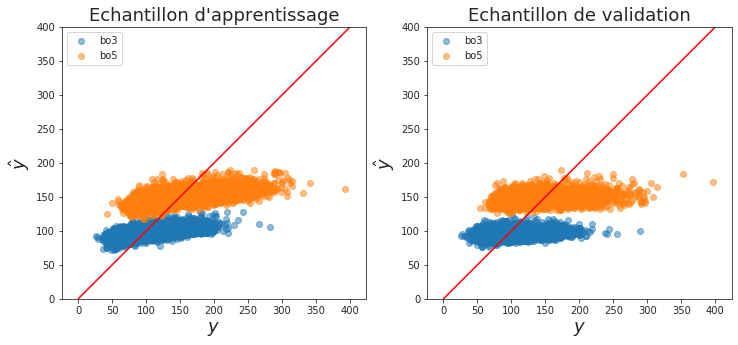

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].scatter(y_train_bo3, y_pred_train_bo3, alpha=0.5, label='bo3')
axs[0].scatter(y_train_bo5, y_pred_train_bo5, alpha=0.5, label='bo5')
axs[0].plot([0,400], [0,400], color='red')
axs[0].axis('equal')
axs[0].set_xlim((0,400))
axs[0].set_ylim((0,400))
axs[0].set_xlabel("$y$",fontsize=18)
axs[0].set_ylabel("$\hat{y}$",fontsize=18)
axs[0].legend()
axs[0].set_title("Echantillon d'apprentissage",fontsize=18)
axs[1].scatter(y_test_bo3, y_pred_test_bo3, alpha=0.5, label='bo3')
axs[1].scatter(y_test_bo5, y_pred_test_bo5, alpha=0.5, label='bo5')
axs[1].plot([0,400], [0,400], color='red')
axs[1].axis('equal')
axs[1].set_xlim((0,400))
axs[1].set_ylim((0,400))
axs[1].set_xlabel("$y$",fontsize=18)
axs[1].set_ylabel("$\hat{y}$",fontsize=18)
axs[1].legend()
axs[1].set_title("Echantillon de validation", fontsize=18)
plt.show()

L'apport des features que nous avons crées reste très faible et la durée du match présente une erreur élevée.  
  
La MSE sur les Bo3 sur notre échantillon test s'élève à 886, ce qui représente une erreur moyenne de 30 minutes ce qui est très élevé pour des matchs durant en moyenne de 1h35 environ.  
Même constat pour les Bo5, où la MSE s'élève cette fois-ci à 2007, représentant une erreur de prédiction de la longueur d'un match de 45 minutes en moyennes, mais nous contstatons cependant une légère baisse suite à l'introduction de nos variables explicatives, même si cette dernière reste marginale.  
  
La conclusion que nous en tirons est qu'il est complexe de prédire la durée d'un match, ce phénomène est très aléatoire et les variables à notre disposition ne permettent pas de prédire de manière précise ce phénomène.  
  
Nous reformulons le problème sous la forme d'une classification binaire, nous voulons prédire si oui ou non un match durera plus de 3h dans un Bo5.

## Classification des matchs de plus de 3h sur les Bo5

In [75]:
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [76]:
y_train_bo5_class = [0 if x<190 else 1 for x in y_train_bo5]
y_test_bo5_class = [0 if x<190 else 1 for x in y_test_bo5]

In [81]:
RF_clf = RandomForestClassifier()
RF_clf_params = {'n_estimators':[100,200,300],
            'max_depth':[2,4,7,15],
            'max_features':[12,'auto', 'sqrt']}

In [91]:
GSCV_RF_clf = GridSearchCV(RF_clf, RF_clf_params, 'recall', cv=3)

In [92]:
GSCV_RF_clf.fit(X_train_bo5,y_train_bo5_class)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Les paramètres du meilleur estimateur sont les suivants.

In [93]:
GSCV_RF_clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [94]:
X_test_bo5 = harmonisation_train_test(X_train_bo5, X_test_bo5)
print('Score Random Forest : %0.2f' % GSCV_RF_clf.best_estimator_.score(X_test_bo5, y_test_bo5_class))

Score Random Forest : 0.80


In [95]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_bo5_class, GSCV_RF_clf.best_estimator_.predict(X_test_bo5))

array([[2343,    7],
       [ 576,   10]])

Encore une fois, le modèle ne parvient pas à détecter les matchs de plus de 3 heures. Ceci peut provenir en partie du problème de sous représentativité de ces matchs, incitant le modèle à se focaliser sur les matchs de mois de 3 heures.

## Conclusion

Les résultats obtenus ne sont pas à la hauteur de nos attentes et sont décevants. La nature du problème semble trop complexe pour être prédite à partir des données à notre disposition. Les étapes de features engineering n'ont pas permis d'améliorer de manière significative la qualité des prédictions faites par nos premiers modèles.